### Multimodal

In [61]:
import jax
import jax.scipy.stats as jst
from jax.random import PRNGKey, normal, split
import matplotlib.pyplot as plt
import numpy as np

from kernels import kernel_factory
from utils import *
from integrators import *

root_seed=12387593871
key = PRNGKey(root_seed)

from test_functions import neg_log_mix, neg_log_mvnormal

mu = 10*jnp.array([1,0])
cov = jnp.eye(2)
params = [(mu, cov),( -mu, cov)]

neg_log_probs = [neg_log_mvnormal(mu, sigma) for mu,sigma in params]
U = neg_log_mix(neg_log_probs, jnp.array([0.5, 0.5]))


key, split_key = split(key)
q_init = normal(split_key, (2, ))

Text(0.5, 0, '$x_1$')

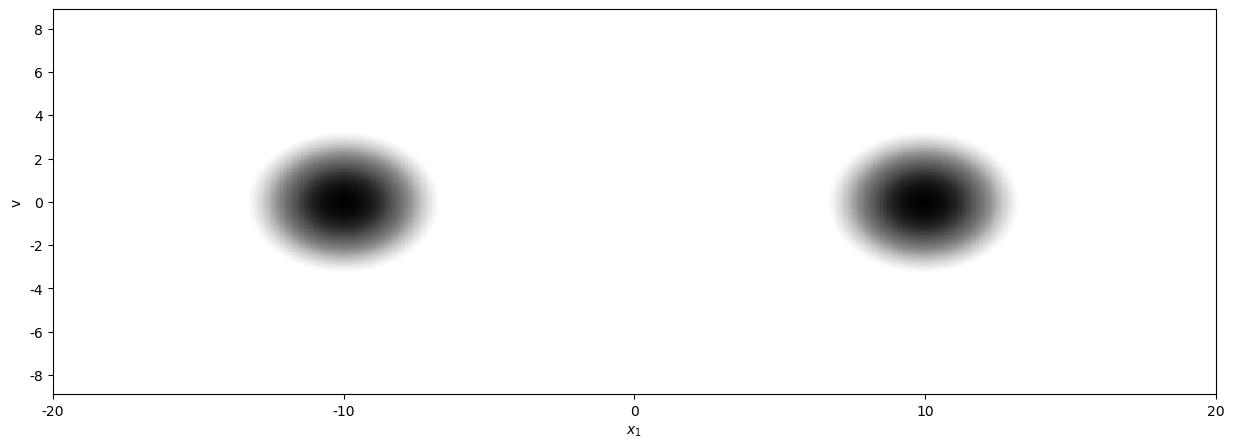

In [62]:
x_lim = [-20, 20]
y_lim = [-9, 9]
res = 500
x, y = np.meshgrid(np.linspace(*x_lim, res), np.linspace(*y_lim, res))
pos = np.dstack((x, y))
logp = -jax.vmap(jax.vmap(U))(pos)

fig, ax = plt.subplots(figsize=(15,5))

# ax.contourf(pos[...,0], pos[...,1], logp, levels=np.linspace(-7.5,-2.5,50), alpha=0.9)
ax.pcolor(logp, vmin=-8, vmax=-2.5, cmap="Greys")
x_labels = [-20,-10,0,10,20]
ax.set_xticks(np.linspace(0,res,len(x_labels)))
ax.set_xticklabels(x_labels)
y_labels = np.arange(-8,9,2)
ax.set_yticks(25+np.linspace(0,res-50,len(y_labels)))
ax.set_yticklabels(y_labels)
ax.set_ylabel("v")
ax.set_xlabel("$x_1$") # actually x_last but it's just a multivariate gaussian

In [63]:
num_warmup = 1000
num_samples = 50000
keys = split(key, num=num_samples+num_warmup)

### M=1

In [64]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.05

init_state, m1hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=20, dual_avg_kwargs=dual_avg_kwargs)

carry, burned_m1hmc_states = jax.lax.scan(m1hmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , m1hmc_states = jax.lax.scan(m1hmc_kernel, carry, keys[num_warmup:,:])

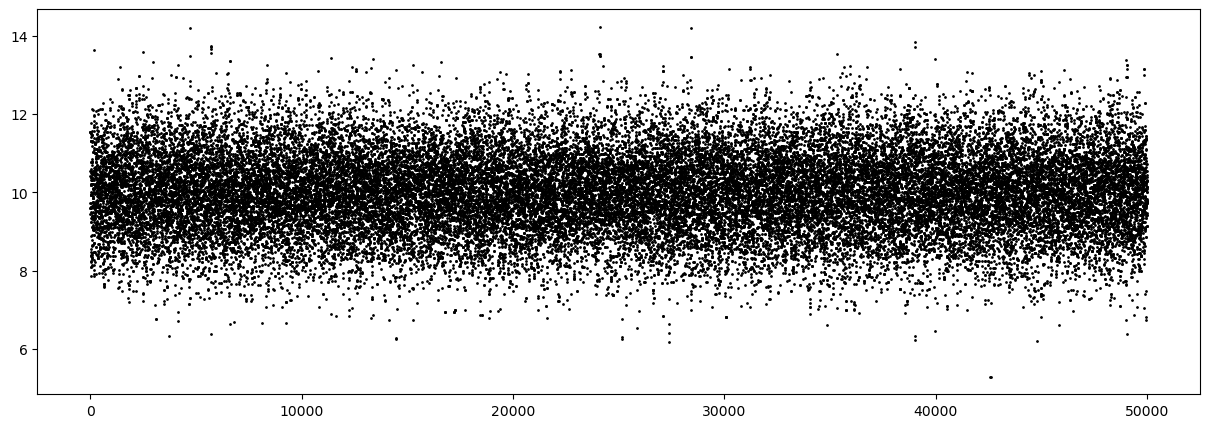

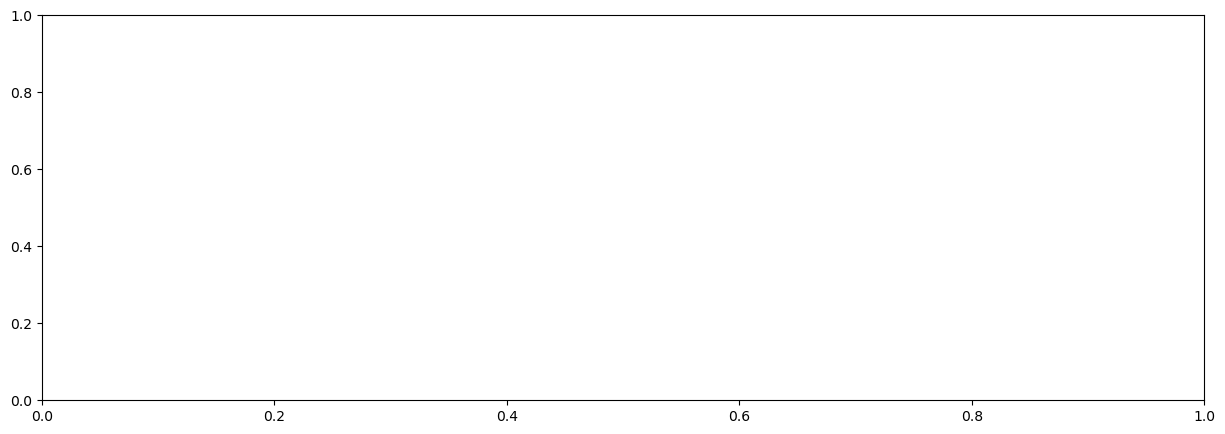

In [65]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(num_samples), m1hmc_states[0][:,0], s=1, c='k')
plot_ac(m1hmc_states[0][:2000,-1], lag=1000, plot_every=10)

Final step size: 1.4663808345794678
Final average acceptance rate: 0.7411433057598039


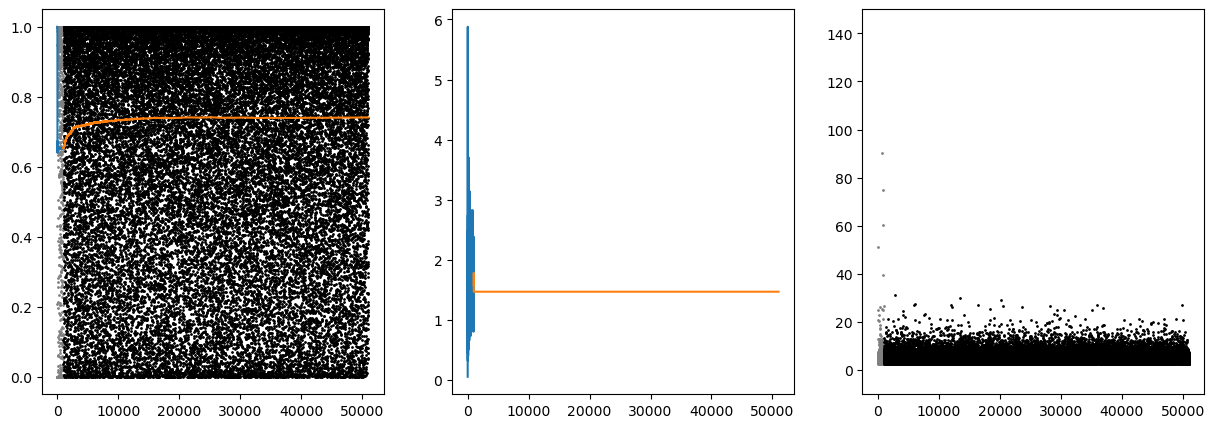

In [66]:
if dual_avg_kwargs != None:
    q, accept_prob, E_new, step_size = [np.concatenate((arr, m1hmc_states[i])) for i, arr in enumerate(burned_m1hmc_states)]
    print(f"Final step size: {step_size[-1]}")

    running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
    print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

    fig, axes = plt.subplots(1,3, figsize=(15,5))
    x = np.arange(num_warmup)

    axes[0].plot(x, running_avg_a_rate[:num_warmup])
    axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
    axes[1].plot(x, step_size[:num_warmup])
    axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')

    x = np.arange(num_warmup, num_samples+num_warmup)
    axes[0].plot(x, running_avg_a_rate[num_warmup:])
    axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
    axes[1].plot(x, step_size[num_warmup:])
    axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')
    axes[2].set_ylim(-10,150)

### M=10

In [77]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.05

init_state, m10hmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=100, dual_avg_kwargs=dual_avg_kwargs, M=10)

carry, burned_m10hmc_states = jax.lax.scan(m10hmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , m10hmc_states = jax.lax.scan(m10hmc_kernel, carry, keys[num_warmup:,:])

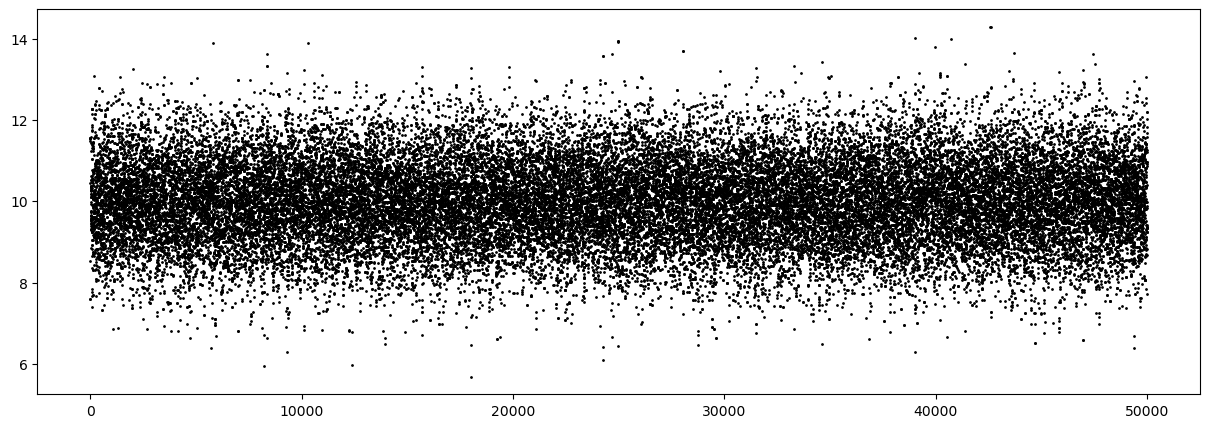

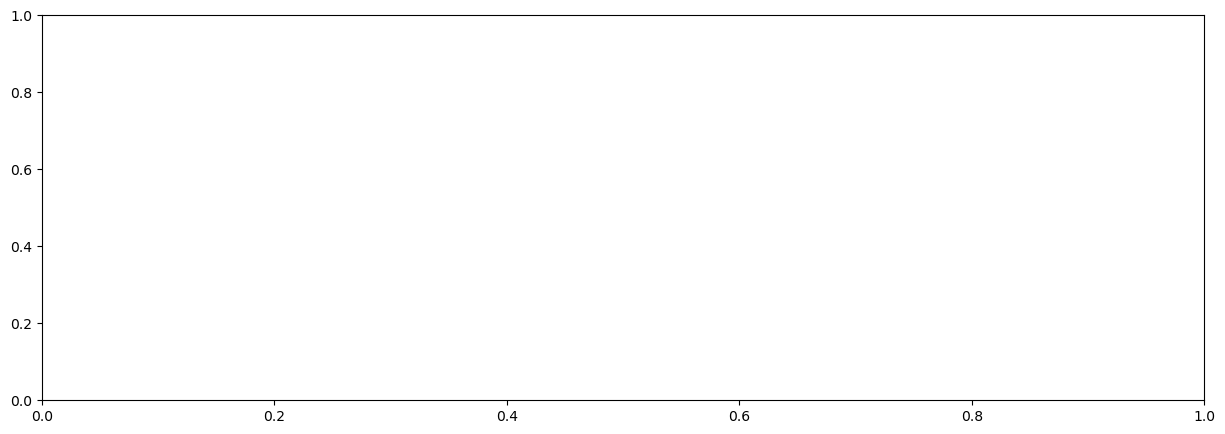

In [68]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(num_samples), m10hmc_states[0][:,0], s=1, c='k')
plot_ac(m10hmc_states[0][:2000,-1], lag=1000, plot_every=10)

Final step size: 4.679309368133545
Final average acceptance rate: 0.7391485906862745


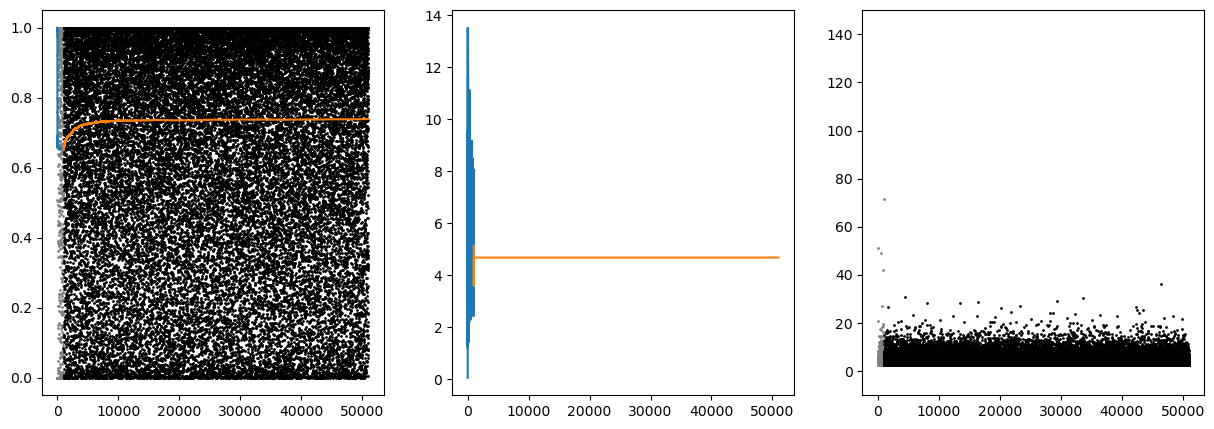

In [69]:
if dual_avg_kwargs != None:
    q, accept_prob, E_new, step_size = [np.concatenate((arr, m10hmc_states[i])) for i, arr in enumerate(burned_m10hmc_states)]
    print(f"Final step size: {step_size[-1]}")

    running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
    print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

    fig, axes = plt.subplots(1,3, figsize=(15,5))
    x = np.arange(num_warmup)

    axes[0].plot(x, running_avg_a_rate[:num_warmup])
    axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
    axes[1].plot(x, step_size[:num_warmup])
    axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


    x = np.arange(num_warmup, num_samples+num_warmup)
    axes[0].plot(x, running_avg_a_rate[num_warmup:])
    axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
    axes[1].plot(x, step_size[num_warmup:])
    axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

    axes[2].set_ylim(-10,150)

### M=0.1

In [70]:
dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# dual_avg_kwargs = None
init_step_size=.05

init_state, m01hmc_kernel = kernel_factory("q_rmhmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs, M=.1)

carry, burned_m01hmc_states = jax.lax.scan(m01hmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , m01hmc_states = jax.lax.scan(m01hmc_kernel, carry, keys[num_warmup:,:])

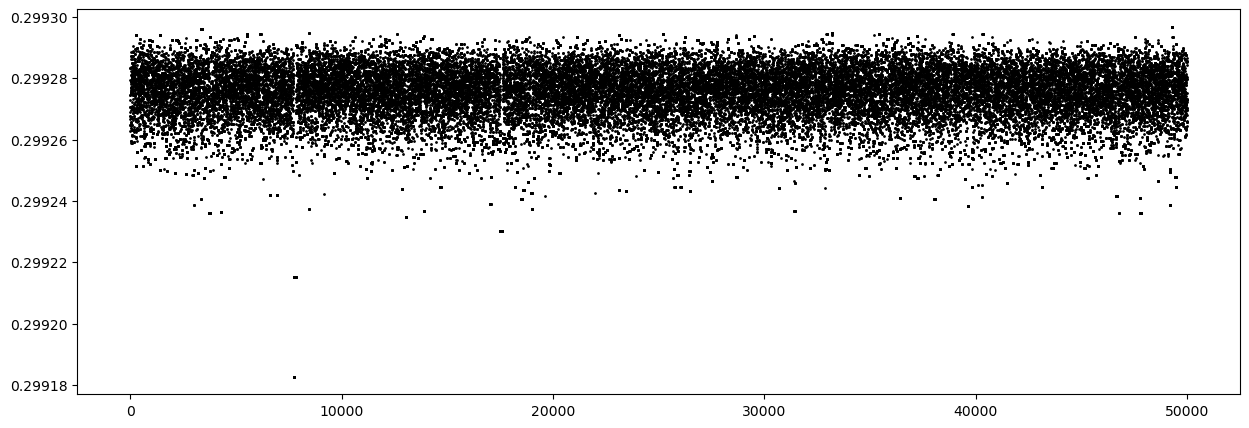

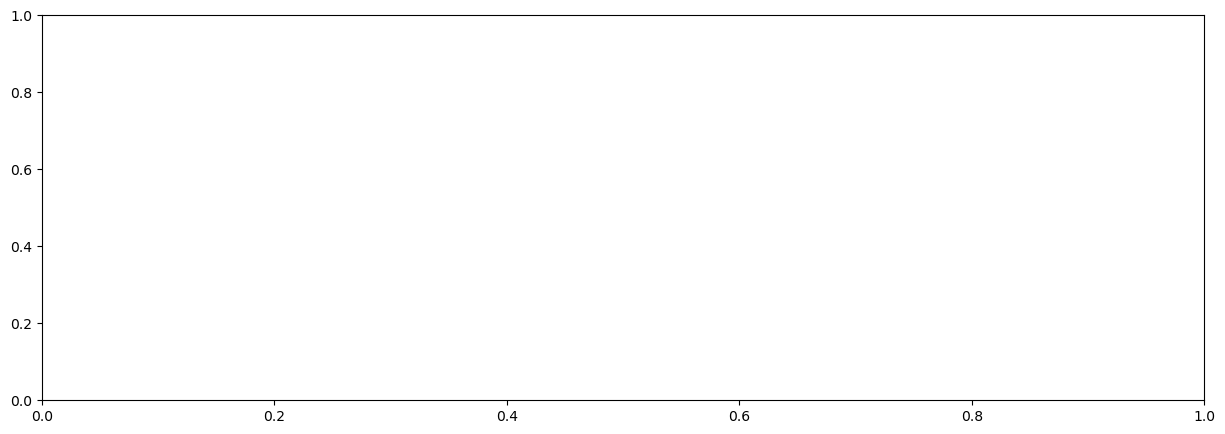

In [71]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(num_samples), m01hmc_states[0][:,0], s=1, c='k')
plot_ac(m01hmc_states[0][:2000,-1], lag=1000, plot_every=10)

Final step size: 2.532238340791082e-06
Final average acceptance rate: 0.6167981387867647


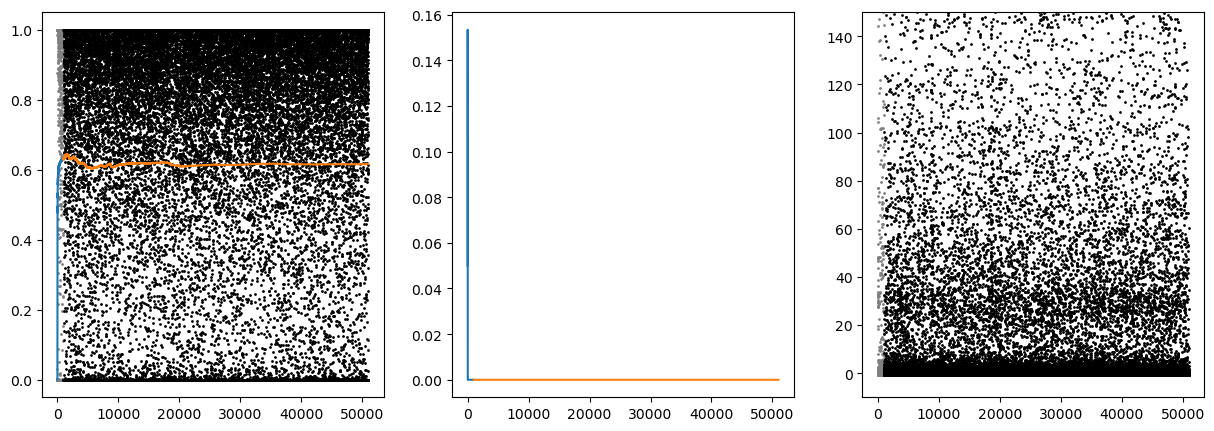

In [72]:
if dual_avg_kwargs != None:
    q, accept_prob, E_new, step_size = [np.concatenate((arr, m01hmc_states[i])) for i, arr in enumerate(burned_m01hmc_states)]
    print(f"Final step size: {step_size[-1]}")

    running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
    print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

    fig, axes = plt.subplots(1,3, figsize=(15,5))
    x = np.arange(num_warmup)

    axes[0].plot(x, running_avg_a_rate[:num_warmup])
    axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
    axes[1].plot(x, step_size[:num_warmup])
    axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


    x = np.arange(num_warmup, num_samples+num_warmup)
    axes[0].plot(x, running_avg_a_rate[num_warmup:])
    axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
    axes[1].plot(x, step_size[num_warmup:])
    axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

    axes[2].set_ylim(-10,150)

### DiagQHMC

In [73]:
# dual_avg_kwargs = {"tune_steps":1000, "target_accept":0.65}
# random_mass_kwargs = {"mu":0, "sigma":1}
random_mass_kwargs = {"mu":0, "sigma":1} 
dual_avg_kwargs = None
init_step_size=.05

init_state, dqhmc_kernel = kernel_factory("hmc", q_init, init_step_size, U, explicit_leapfrog, gather_stats=True, num_steps=50, dual_avg_kwargs=dual_avg_kwargs, random_mass_kwargs=random_mass_kwargs)

carry, burned_dqhmc_states = jax.lax.scan(dqhmc_kernel, init_state, keys[:num_warmup,:]) # warm up
carry , dqhmc_states = jax.lax.scan(dqhmc_kernel, carry, keys[num_warmup:,:])

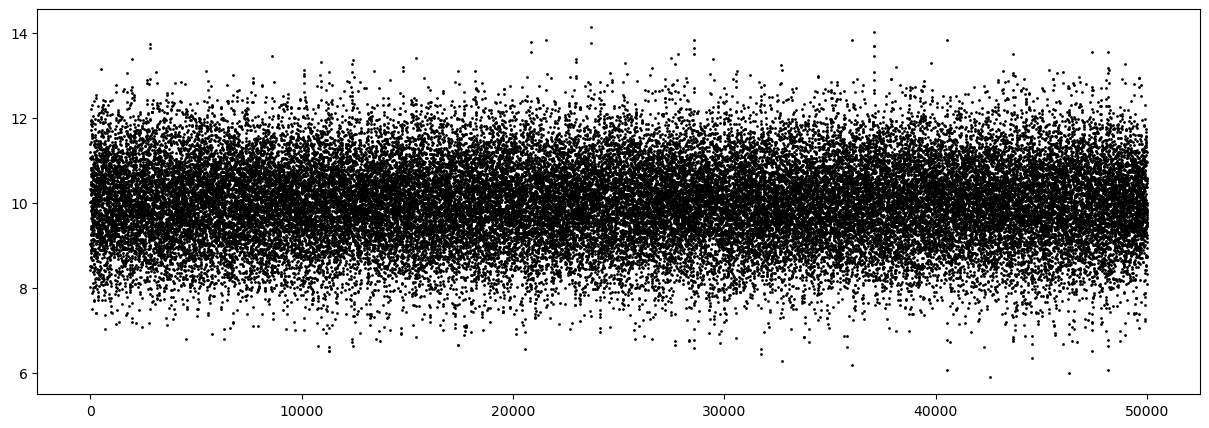

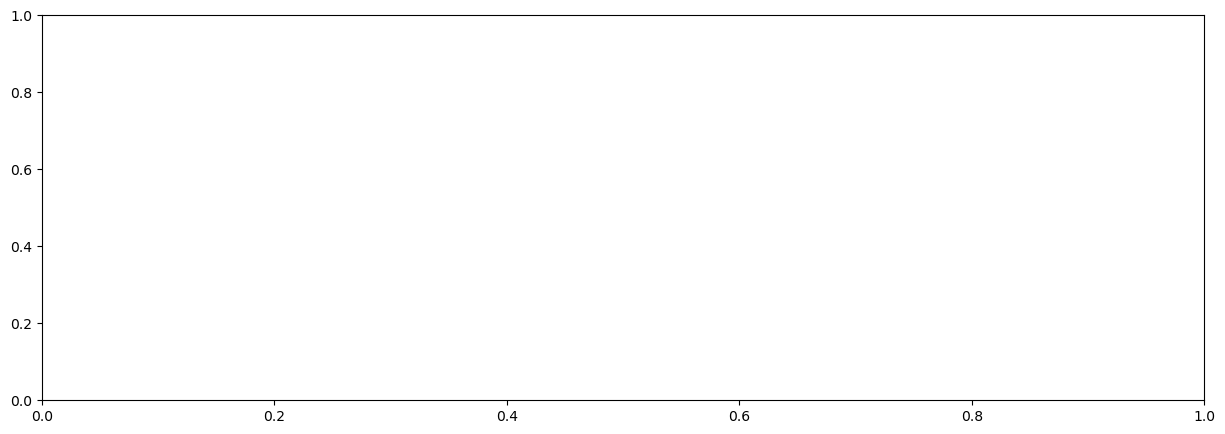

In [74]:
plt.figure(figsize=(15,5))
plt.scatter(np.arange(num_samples), dqhmc_states[0][:,0], s=1, c='k')
plot_ac(dqhmc_states[0][:2000,-1], lag=1000, plot_every=10)

In [75]:
if dual_avg_kwargs != None:
    q, accept_prob, E_new, step_size = [np.concatenate((arr, dqhmc_states[i])) for i, arr in enumerate(burned_dqhmc_states)]
    print(f"Final step size: {step_size[-1]}")

    running_avg_a_rate = np.cumsum(accept_prob)/np.arange(1,num_samples+num_warmup+1)
    print(f"Final average acceptance rate: {running_avg_a_rate[-1]}")

    fig, axes = plt.subplots(1,3, figsize=(15,5))
    x = np.arange(num_warmup)

    axes[0].plot(x, running_avg_a_rate[:num_warmup])
    axes[0].scatter(x, accept_prob[:num_warmup], s=1, c='grey')
    axes[1].plot(x, step_size[:num_warmup])
    axes[2].scatter(x, E_new[:num_warmup], s=1, c='grey')


    x = np.arange(num_warmup, num_samples+num_warmup)
    axes[0].plot(x, running_avg_a_rate[num_warmup:])
    axes[0].scatter(x, accept_prob[num_warmup:], s=1, c='k')
    axes[1].plot(x, step_size[num_warmup:])
    axes[2].scatter(x, E_new[num_warmup:], s=1, c='k')

    axes[2].set_ylim(-10,150)

### Result comparison

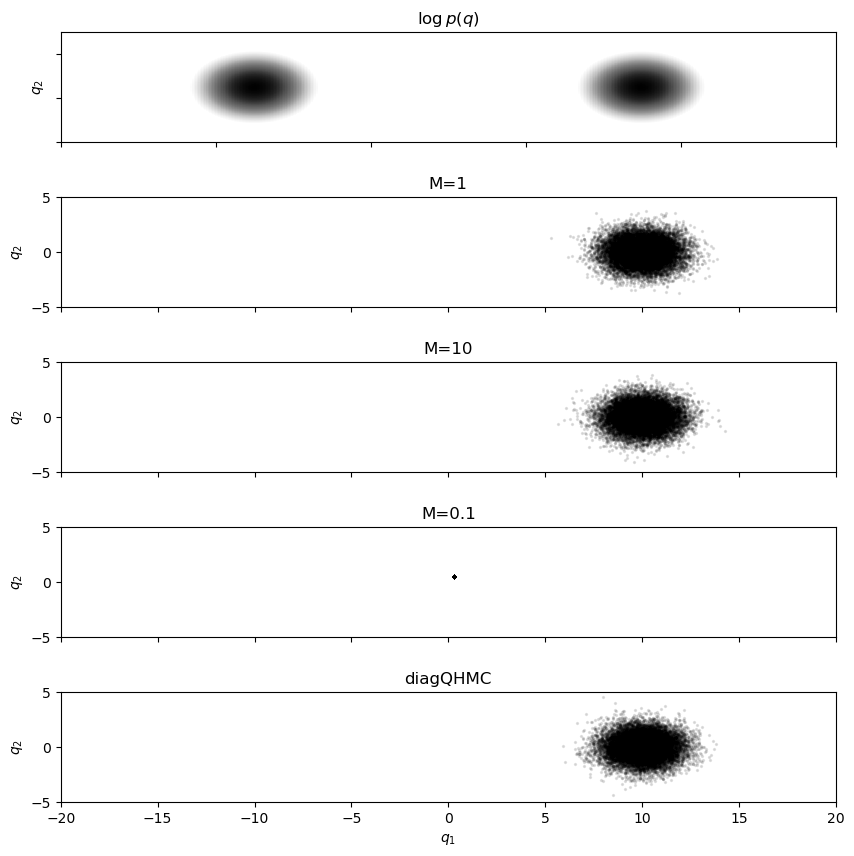

In [76]:
x_lim = [-20, 20]
y_lim = [-5, 5]
res = 500
x, y = np.meshgrid(np.linspace(*x_lim, res), np.linspace(*y_lim, res))
pos = np.dstack((x, y))
logp = -jax.vmap(jax.vmap(U))(pos)

fig, ax = plt.subplots(5,1, figsize=(10,10))

# ax.contourf(pos[...,0], pos[...,1], logp, levels=np.linspace(-7.5,-2.5,50), alpha=0.9)
ax[0].pcolor(logp, vmin=-8, vmax=-2.5, cmap="Greys")
# x_labels = [-20,-10,0,10,20]
# ax[0].set_xticks(np.linspace(0,res,len(x_labels)))
ax[0].set_xticklabels([])
# y_labels = np.arange(-5,6,2)
# ax[0].set_yticks(25+np.linspace(0,res-50,len(y_labels)))
ax[0].set_yticklabels([])
ax[0].set_ylabel("$q_2$")
# ax[0].set_xlabel("$q_1$") # actually x_last but it's just a multivariate gaussian
ax[0].set_title(f"$\log p(q)$")

ax[1].set_title("M=1")
ax[1].scatter(*m1hmc_states[0][::3,-2:].T, s=2, c="k", alpha=0.1)

ax[2].set_title("M=10")
ax[2].scatter(*m10hmc_states[0][::3,-2:].T, s=2, c="k", alpha=0.1)

ax[3].set_title("M=0.1")
ax[3].scatter(*m01hmc_states[0][::3,-2:].T, s=2, c="k", alpha=0.1)

ax[4].set_title("diagQHMC")
ax[4].scatter(*dqhmc_states[0][::3,-2:].T, s=2, c="k", alpha=0.1)

for i in range(1,4):
    ax[i].set_ylabel("$q_2$") 
    ax[i].set_xlim(*x_lim)
    ax[i].set_ylim(*y_lim)
    ax[i].set_xticklabels([])

ax[-1].set_ylabel("$q_2$") 
ax[-1].set_xlabel("$q_1$") 
ax[-1].set_xlim(*x_lim)
ax[-1].set_ylim(*y_lim)
plt.subplots_adjust(hspace=0.5)